<a href="https://colab.research.google.com/github/chanhyeong00/machine_learning_study/blob/main/pytorch-computer%20vision/%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B6%84%EB%A5%98/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 모델 구조 및 데이터 시각화

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%%capture
!unzip pet.zip

pet 데이터세트는 약 8,000개의 훈련용 데이터와 약 2,000개의 테스트 데이터로 이뤄져있다.

이 데이터세트를 VGG-16 모델에서 학습한 방식과 동일한 형태로 변환한 후 데이터로더를 적용해본다.

우선 하이퍼파라미터 선언 및 이미지 변환을 하겠다.

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            # 이미지 크기 256x256(224x224보다 약간 크게)
            transforms.Resize(256),
            # 224x224로 중앙 자르기를 수행(VGG-16 모델이 224x224 크기의 이미지로 학습한 모델임)
            # 탐지하려는 객체가 중앙에 위치할 확률이 높으므로
            # 불필요한 지역 특징을 제거하기 위해 224x224 크기보다 더 큰 이미지 크기로 조절하고 자르기 수행
            # 약간 더 큰 이미지로 변경 후 자르면 객체의 특징을 최대한 유지 가능
            transforms.CenterCrop(224),
            # ToTensor() 객체는 [0.0, 1.0] 크기로
            transforms.ToTensor(),
            transforms.Normalize(
                # 이미지넷 데이터세트에 대한 대푯값
                mean=[0.48235, 0.45882, 0.40784],
                # RGB 값을 0.0~1.0으로 정규화한 값 사용
                std=[1.0/255.0, 1.0/255.0, 1.0/225.0]
            )
        ]
    )
}
# 이미지 폴더 데이터세트 클래스 ImageFolder
# train과 test는 cat과 dog folder로 나눠져 있음-> 그 안에 사진들
# ImageFolder는 이러한 구조를 가진 폴더를 자동으로 레이블을 구분해준다
train_dataset = ImageFolder("pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("pet/test", transform=hyperparams["transform"])

# DataLoader
train_dataloader = DataLoader(
    train_dataset, batch_size = hyperparams['batch_size'], shuffle=True,
    drop_last=True)
test_dataloader = DataLoader(
    test_dataset, batch_size = hyperparams['batch_size'], shuffle=True,
    drop_last=True)

**ToTensor() 객체는 [0.0, 1.0] 크기로**


std=[1.0/255.0, 1.0/255.0, 1.0/255.0]는 RGB 값을 0~1 사이로 정규화 하기 위함

## 데이터 시각화(tensor 변환, 역정규화)

Tensor 객체는 이미지 형태를 (H x W x C)에서 (C x H x W) 로 변환



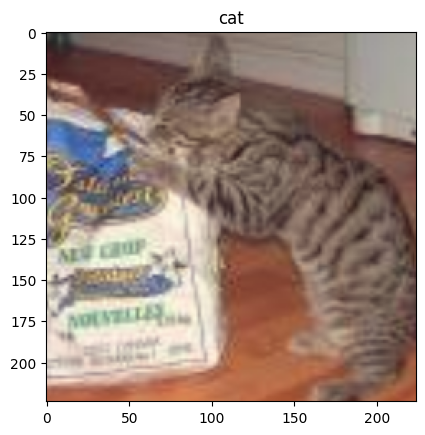

In [4]:
import numpy as np
from matplotlib import pyplot as plt

mean=[0.48235, 0.45882, 0.40784]
std=[1.0/255.0, 1.0/255.0, 1.0/255.0]

# 데이터로더는 Iterator로 Iterabel 형식의 멤버를 순차적으로 반환할 수 있는 객체이다.
# next는 iter의 다음값 리스트로 반환해줌 -> 첫 번째 배치의 이미지와 레이블 추출
images, labels = next(iter(train_dataloader))
for image, label in zip(images, labels):
  # Tensor 객체는 이미지 형태를 (H x W x C)에서 (C x H x W) 로 변환
  # 그러므로 다시 (H x W x C) 형태로 변환하기 위해 transpose
  image = image.numpy().transpose((1, 2, 0))

  # 역정규화 수행
  # 정규화된 이미지= (이미지 - 평균) / std
  # 이미지 = (정규화된 이미지 * std + mean)
  # (이미지 * std + mean) 에서 텐서 변환 클래스(ToTensor)에서 픽셀 범위가 [0, 255]에서 [0.0, 1.0]으로
  # 재조정됐으므로 픽셀 비율에 255배 곱한 후 uint8 형식으로 변환
  image = ((std * image + mean) * 255).astype(np.uint8)

  plt.imshow(image)

  # label도 텐서 형식으로 변환됐으므로 int 형식으로 변환하고
  # 데이터세트의 classes 메서드로 레이블을 매핑한다.
  # classes 메서드는 디렉터리의 폴더 이름과 동일한 값을 갖는다.
  plt.title(train_dataset.classes[int(label)])
  plt.show()
  break

**transforms.ToTensor()로 반환된 Tensor 객체는 이미지 형태를 (H x W x C)에서 (C x H x W) 로 변환**

## VGG-16 모델 불러오기 및 게층 구조 출력

In [5]:
from torchvision import models

model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 100MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 미세 조정(Fine-tuning) 및 모델 학습

### Fine-tuning

In [6]:
from torch import nn

model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

개, 고양이 2개로 출력하는 것을 볼 수 있음

VGG-16 모델 학습

In [7]:
import torch
from torch import optim


device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr = hyperparams["learning_rate"])

for epoch in range(hyperparams["epochs"]):
  cost = 0.0

  for images, classes in train_dataloader:
    images = images.to(device)
    classes = classes.to(device)

    output = model(images) # 순전파
    loss = criterion(output, classes)

    optimizer.zero_grad() # 옵티마이저 기울기 초기화
    loss.backward() # 역전파
    optimizer.step() # 반영

    cost += loss

  cost = cost / len(train_dataloader)
  print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :    1, Cost : 0.295
Epoch :    2, Cost : 0.085
Epoch :    3, Cost : 0.064
Epoch :    4, Cost : 0.043
Epoch :    5, Cost : 0.028


In [11]:
from torch.nn import functional as F

with torch.no_grad():
  model.eval()

  acc = 0.0
  for images, classes in test_dataloader:
    images = images.to(device)
    classes = classes.to(device)

    outputs = model(images)
    probs = F.softmax(outputs, dim=-1)
    outputs_classes = torch.argmax(probs, dim=-1)

    acc += int(torch.eq(classes, outputs_classes).sum())

  print(f"acc@1 : {acc / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")

torch.save(model.state_dict(), "VGG16.pt")
print("Saved the model weights")

acc@1 : 97.72%
Saved the model weights


acc@1은 상위 1개 레이블에 대한 정확도를 측정하므로

같음 비교 함수(torch.eq)로 테스트 데이터세트의 레이블(classes)과

모델 예측 결과(outputs_classes)를 비교한다.

같음비교함수(eq)는 두 텐서의 값이 같다면 참(True) 값을 반환하므로 합(sum) 메서드로 옳게 예측된 개수를 acc 변수에 누적해 더한다.

acc 변수에 예측이 성공한 개수가 저장됐으므로 전체 데이터 개수를 나눠 테스트 데이터세트에 대한 예측 정확도를 계산한다.

- acc를 테스트 데이터 세트의 전체 크기로 나누어 정확도를 계산합니다.
- 이것은 테스트 데이터의 정확도를 퍼센트로 표시하기 위해 100을 곱합니다.
- 마지막으로 소수점 이하 두 자리까지만 표시하기 위해 :.2f를 사용합니다.